In [1]:
import sys
sys.path.insert(0, "C:\\Users\\geork\\projects\\AIThesis\\src\\src")

In [2]:
from dataset_reader import DatasetReaderCSV
from pathlib import Path

path = Path("C:\\Users\\geork\\projects\\AIThesis\\src\\analysis\\ThesisChapters\\5_3\\dataset.csv")
reader = DatasetReaderCSV(path)
reader.read()
df = reader.convert_to_dataframe()
df = df.drop(columns=["Id", "Position", "Path", "GifPath", "Head_Collision_XYZ_index"], errors="ignore")
df = df.drop(columns=["CarProfile"], errors="ignore")
#df = df.drop(columns=["Front_Height", "Hood_Front_Width", "Hood_Back_Width", "Hood_Length", "Hood_Angle", "Windscreen_Length", "Windscreen_Angle"])
# df["CarProfile"] = df["CarProfile"].astype("category")
# df['CarProfile'] = df['CarProfile'].cat.codes
df

,Velocity,Translation,Rotation,Head_Collision_X,Head_Collision_Y,Head_Collision_Z,Bumber_Height,Front_Hood_Height,Bumber_Hood_Angle,Hood_Length,Back_Hood_Height
0,100,-200,0,975.240,-251.831,990.123,770,740,16,1150,980
1,100,-200,120,188.862,-205.223,1030.872,770,740,16,1150,980
2,100,-200,150,371.333,-266.905,1037.072,770,740,16,1150,980
3,100,-200,180,1395.245,-79.044,1009.817,770,740,16,1150,980
4,100,-200,210,284.273,-56.703,1024.811,770,740,16,1150,980
...,...,...,...,...,...,...,...,...,...,...,...
1181,80,400,300,158.647,396.219,1177.354,580,900,11,1160,1130
1182,80,400,30,745.420,705.368,1155.139,580,900,11,1160,1130
1183,80,400,330,319.203,334.512,1155.007,580,900,11,1160,1130
1184,80,400,60,303.420,496.181,1160.272,580,900,11,1160,1130


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame
# Define features (X) and targets (y)
X = df.drop(columns=['Head_Collision_X', 'Head_Collision_Y', 'Head_Collision_Z'])
y = df[['Head_Collision_X', 'Head_Collision_Y', 'Head_Collision_Z']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
inputs_names = X.columns.tolist()

In [5]:
import torch

dataset = {}
dataset['train_input'] = torch.tensor(X_train, dtype=torch.float32)
dataset['train_label'] = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
dataset['test_input'] = torch.tensor(X_test, dtype=torch.float32)
dataset['test_label'] = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
#nomizo prepei na ftiakso ena dataset me kleidia train_input kai train_label kai na to peraso sto model.s
print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print("Test data shape: {}".format(dataset['test_input'].shape))
print("Test target shape: {}".format(dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([948, 8])
Train target shape: torch.Size([948, 3])
Test data shape: torch.Size([238, 8])
Test target shape: torch.Size([238, 3])


In [6]:
from kan import *

image_folder = 'video_img'
model = KAN(width=[8, 10, 3, 3], grid=10, k=3, seed=0)

In [7]:
def train_mse():
    with torch.no_grad():
        predictions = model(dataset['train_input'])
        mse = torch.nn.functional.mse_loss(predictions, dataset['train_label'])
    return mse

def test_mse():
    with torch.no_grad():
        predictions = model(dataset['test_input'])
        mse = torch.nn.functional.mse_loss(predictions, dataset['test_label'])
    return mse

results = model.train(dataset, opt="LBFGS", metrics=(train_mse, test_mse),
                      loss_fn=torch.nn.MSELoss(), steps=15, lamb=0.01, lamb_entropy=2., save_fig=True, img_folder=image_folder)

train loss: 4.22e+01 | test loss: 3.39e+01 | reg: 1.13e+02 : 100%|██| 15/15 [13:54<00:00, 55.61s/it]


In [8]:
print(results['train_mse'][-1], results['test_mse'][-1])

1780.942626953125 1149.9361572265625


In [9]:
inputs_names

['Velocity',
 'Translation',
 'Rotation',
 'Bumber_Height',
 'Front_Hood_Height',
 'Bumber_Hood_Angle',
 'Hood_Length',
 'Back_Hood_Height']

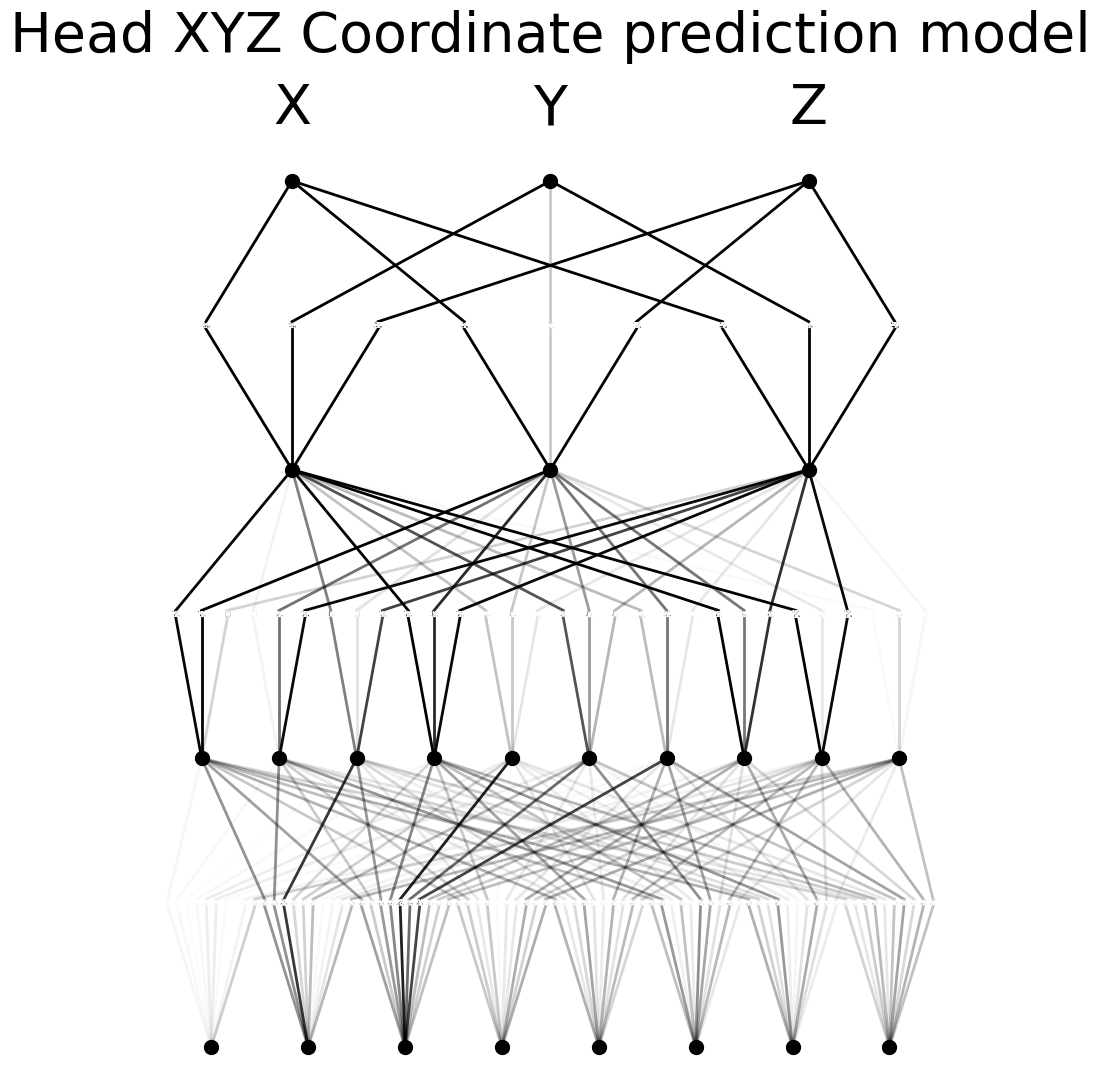

In [11]:
model.plot(beta=1, scale=1, out_vars=['X', "Y", "Z"], title="Head XYZ Coordinate prediction model", tick=True)

In [12]:
from torch.utils.data import DataLoader, TensorDataset

test_dataset = TensorDataset(dataset["test_input"], dataset["test_label"])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        predictions.append(outputs)

predictions = torch.cat(predictions, dim=0)

c:\Users\geork\projects\AIThesis\src\.venv\lib\site-packages\kan\KAN.py:327: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


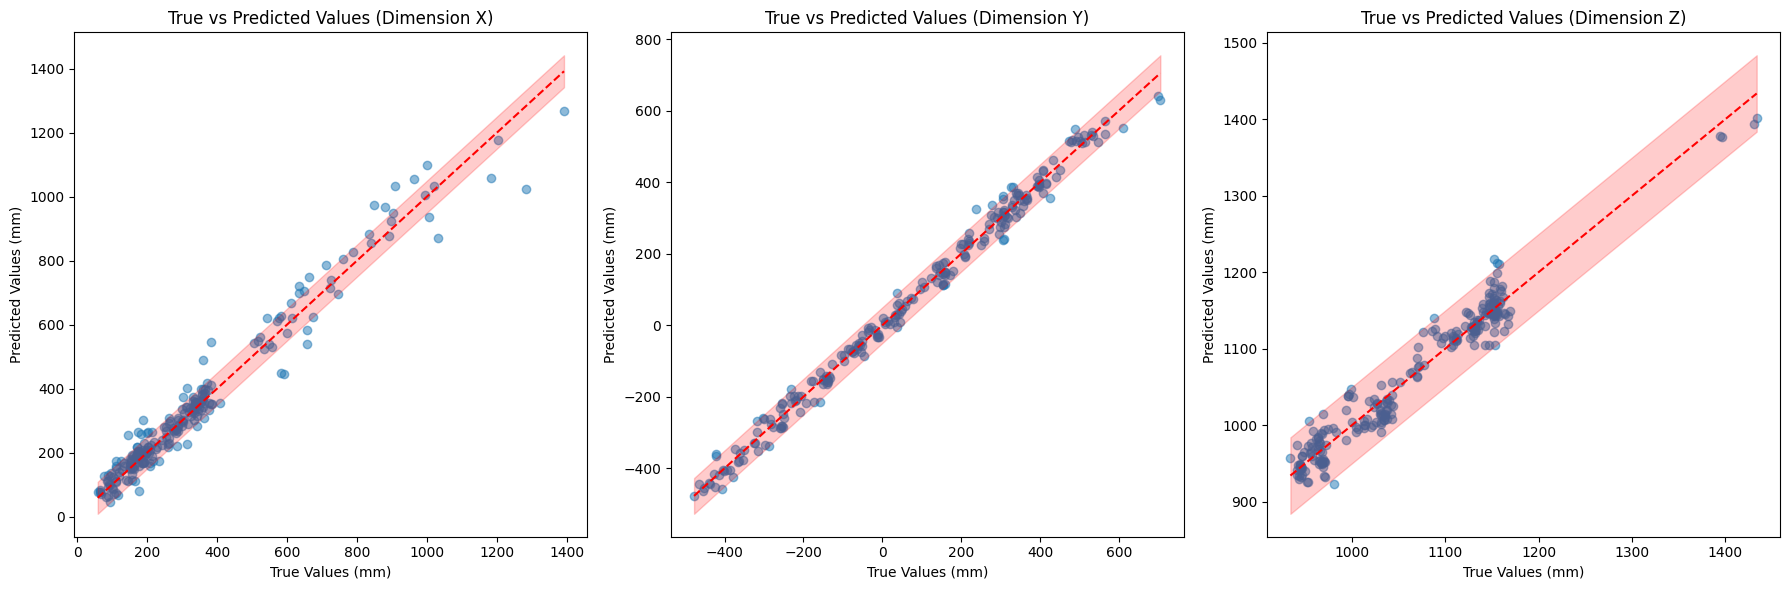

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming y_test is the true values and y_pred are the predictions
y_test = y_test.reset_index(drop=True).rename(columns={'Head_Collision_X': 'True_Head_Collision_X', 
                                                       "Head_Collision_Y": "True_Head_Collision_Y",
                                                       "Head_Collision_Z": "True_Head_Collision_Z"})
y_test_df = y_test
y_pred_df = pd.DataFrame(predictions, columns=['Predicted_Head_Collision_X',
                                          "Predicted_Head_Collision_Y",
                                          "Predicted_Head_Collision_Z"])

# Merge true and predicted values into a single DataFrame
comparison_df = pd.concat([y_test_df, y_pred_df], axis=1)

# Define the error range in mm
error_range = 50  # 25 mm on each side of the perfect prediction line

# Plot true vs predicted values for each dimension separately
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to plot with shaded error region
def plot_with_error_region(ax, true_vals, pred_vals, title):
    ax.scatter(true_vals, pred_vals, alpha=0.5)
    ax.set_xlabel('True Values (mm)')
    ax.set_ylabel('Predicted Values (mm)')
    ax.set_title(title)

    # Plot line of perfect prediction
    ax.plot([true_vals.min(), true_vals.max()], 
            [true_vals.min(), true_vals.max()], 
            color='red', linestyle='--')  
    
    # Plot shaded error region
    ax.fill_between([true_vals.min(), true_vals.max()], 
                    [true_vals.min() - error_range, true_vals.max() - error_range],
                    [true_vals.min() + error_range, true_vals.max() + error_range],
                    color='red', alpha=0.2)  # Light red shaded region

# Plot for the first dimension (X)
plot_with_error_region(axes[0], 
                       comparison_df['True_Head_Collision_X'], 
                       comparison_df['Predicted_Head_Collision_X'], 
                       'True vs Predicted Values (Dimension X)')

# Plot for the second dimension (Y)
plot_with_error_region(axes[1], 
                       comparison_df['True_Head_Collision_Y'], 
                       comparison_df['Predicted_Head_Collision_Y'], 
                       'True vs Predicted Values (Dimension Y)')

# Plot for the third dimension (Z)
plot_with_error_region(axes[2], 
                       comparison_df['True_Head_Collision_Z'], 
                       comparison_df['Predicted_Head_Collision_Z'], 
                       'True vs Predicted Values (Dimension Z)')

plt.tight_layout()
plt.show()
